In [1]:
!pip install torch torchvision tqdm

## SET LIBRARY

In [2]:
import os, time
from glob import glob
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

## LOAD DATA

In [ ]:
#!pwd
#!gsutil cp gs://supark-sandbox/BelgiumTSC_Training.zip ./
#!unzip BelgiumTSC_Training.zip
#!mv Training train
#!gsutil cp gs://supark-sandbox/BelgiumTSC_Testing.zip ./
#!unzip BelgiumTSC_Testing.zip
#!mv Testing valid

In [3]:
idx_train = {}
idx_valid = {}
for i in ('train','valid'):
    path = os.path.join('/jet/prs/workspace/',i)
    paths = [sub for sub in os.listdir(path) if os.path.isdir(os.path.join(path, sub))]
    print('Label size: {}'.format(len(paths)))
    for p in paths:
        files = glob(os.path.join(path, p, '*.ppm'))
        #print('Label {} size: {}'.format(p, len(files)))
        if i == 'train':
            idx_train[str(p)] = len(files)
        else:
            idx_valid[str(p)] = len(files)
idx_lbl = pd.concat([pd.Series(idx_train),pd.Series(idx_valid)], axis=1, join='inner')
idx_lbl.columns = ('train','valid')
idx_lbl.head()

Label size: 62
Label size: 62


,train,valid
00000,15,6
00001,110,27
00002,13,7
00003,15,6
00004,15,12


In [4]:
# from torchvision import transforms
path = '/jet/prs/workspace/'
transform_fn = transforms.Compose([transforms.Resize((224,224)),
                                   #transforms.RandomHorizontalFlip(),
                                   #transforms.RandomRotation(0.2),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder(os.path.join(path,'train'), transform_fn)
valid = ImageFolder(os.path.join(path,'valid'), transform_fn)

In [5]:
print(train.class_to_idx)
print(train.classes)

{'00000': 0, '00001': 1, '00002': 2, '00003': 3, '00004': 4, '00005': 5, '00006': 6, '00007': 7, '00008': 8, '00009': 9, '00010': 10, '00011': 11, '00012': 12, '00013': 13, '00014': 14, '00015': 15, '00016': 16, '00017': 17, '00018': 18, '00019': 19, '00020': 20, '00021': 21, '00022': 22, '00023': 23, '00024': 24, '00025': 25, '00026': 26, '00027': 27, '00028': 28, '00029': 29, '00030': 30, '00031': 31, '00032': 32, '00033': 33, '00034': 34, '00035': 35, '00036': 36, '00037': 37, '00038': 38, '00039': 39, '00040': 40, '00041': 41, '00042': 42, '00043': 43, '00044': 44, '00045': 45, '00046': 46, '00047': 47, '00048': 48, '00049': 49, '00050': 50, '00051': 51, '00052': 52, '00053': 53, '00054': 54, '00055': 55, '00056': 56, '00057': 57, '00058': 58, '00059': 59, '00060': 60, '00061': 61}
['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '000

In [6]:
def imshow(tnsr):
    tnsr = tnsr.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tnsr = std * tnsr + mean
    tnsr = np.clip(tnsr, 0, 1)
    plt.imshow(tnsr)

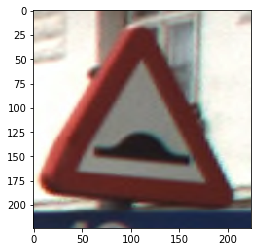

In [7]:
imshow(train[50][0])

In [8]:
g_train = DataLoader(train, batch_size=32, num_workers=3, shuffle=True)
g_valid = DataLoader(valid, batch_size=32, num_workers=3, shuffle=True)
dataloader = {'train': g_train, 'valid': g_valid}
dataset_sizes = {'train':len(g_train.dataset),'valid':len(g_valid.dataset)}

## SET GRAPH

In [ ]:
class Gph(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.drop2 = nn.Dropout2d()
        self.fc1 = nn.Linear(359552, 128)
        self.fc2 = nn.Linear(128, 62)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.drop2(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
gph = Gph()    
if torch.cuda.is_available():
    gph = gph.cuda()

## SET PRETRAINED GRAPH

In [ ]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [79]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [ ]:
vgg.classifier[6].out_features = 2
for param in vgg.features.parameters(): param.requires_grad = False

In [ ]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [ ]:
x_input, y_label = next(iter(dataloader['train']))
x_input = x_input.cuda()
y_label = y_label.cuda()
print(x_input.size())
print(y_label.size())

In [ ]:
#gph(x_input)
vgg(x_input)

## TRAIN

In [ ]:
learning_rate = 0.001
optimizer = optim.SGD(gph.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
def train_gph(gph, optimizer, dataloader, phase='train', volatile=False):
    if phase == 'train':
        gph.train()
    if phase == 'valid':
        gph.eval()
        volatile = True

    running_loss = 0.0
    running_corrects = 0
    running_counts = 0

    for idx, (x_input, y_label) in enumerate(dataloader[phase]):
        if torch.cuda.is_available():
            x_input, y_label = x_input.cuda(), y_label.cuda()
        x_input, y_label = Variable(x_input,volatile), Variable(y_label)

        if phase == 'train':
            optimizer.zero_grad()
        y_prob = gph(x_input)
        _, y_pred = torch.max(y_prob, 1)
        loss = F.nll_loss(y_prob, y_label)

        if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        running_corrects += torch.sum(y_pred == y_label.data).item()
        running_counts += len(y_pred)

    epoch_loss = running_loss / running_counts
    epoch_acc = running_corrects / running_counts
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [ ]:
train_loss, train_acc = [],[]
valid_loss, valid_acc = [],[]
for epoch in range(1,16):
    epoch_loss, epoch_acc = train_gph(gph, optimizer, dataloader, phase='train')
    vld_loss, vld_acc = train_gph(gph, optimizer, dataloader, phase='valid')
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    valid_loss.append(vld_loss)
    valid_acc.append(vld_acc)

In [ ]:
plt.plot(range(1,len(train_loss)+1),train_loss,'bo',label = 'train loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,'r',label = 'valid loss')
plt.legend()

In [ ]:
plt.plot(range(1,len(train_acc)+1),train_acc,'bo',label = 'train accuracy')
plt.plot(range(1,len(valid_acc)+1),valid_acc,'r',label = 'valid accuracy')
plt.legend()

## TRANSFER LEARNING

In [ ]:
train_loss, train_acc = [],[]
valid_loss, valid_acc = [],[]
for epoch in range(1,16):
    epoch_loss, epoch_acc = train_gph(vgg, optimizer, dataloader, phase='train')
    vld_loss, vld_acc = train_gph(vgg, optimizer, dataloader, phase='valid')
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    valid_loss.append(vld_loss)
    valid_acc.append(vld_acc)

## PRECONVOLUTED DATASET

In [ ]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [ ]:
vgg.classifier[6].out_features = 2
vgg_feats = vgg.features
for param in vgg_feats.parameters(): param.requires_grad = False

In [ ]:
# SANITY CHECK
x_input, y_label = next(iter(dataloader['train']))
x_input = x_input.cuda()
y_label = y_label.cuda()
print(x_input.size())
print(y_label.size())

In [ ]:
vgg_feats(x_input).view(32,-1).size()

In [ ]:
vgg.classifier(vgg_feats(x_input).view(32,-1)).size()

In [ ]:
def featdataset(dataloader, phase, gph):
    x_featured = []
    y_featured = []
    for (x_input, y_label) in dataloader[phase]:
        if torch.cuda.is_available():
            x_input, y_label = x_input.cuda(), y_label.cuda()
        x_input, y_label = Variable(x_input), Variable(y_label)
        output = gph(x_input)
        x_featured.extend(output.data.view(output.data.size(0),-1).cpu().numpy())
        y_featured.extend(y_label.data.cpu().numpy())
    x_featured = np.concatenate([[feat] for feat in x_featured])
    
    return (x_featured, y_featured)

In [ ]:
x_train, y_train = featdataset(dataloader, 'train', vgg_feats)
x_valid, y_valid = featdataset(dataloader, 'valid', vgg_feats)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [ ]:
train = MyDataset(x_train, y_train)
valid = MyDataset(x_valid, y_valid)

In [ ]:
g_train = DataLoader(train, batch_size=32, num_workers=3, shuffle=True)
g_valid = DataLoader(valid, batch_size=32, num_workers=3, shuffle=True)
dataloader = {'train': g_train, 'valid': g_valid}
dataset_sizes = {'train':len(g_train.dataset),'valid':len(g_valid.dataset)}

In [ ]:
# SANITY CHECK
x_input, y_label = next(iter(dataloader['train']))
x_input = x_input.cuda()
y_label = y_label.cuda()
print(x_input.size())
print(y_label.size())

In [ ]:
learning_rate = 0.0001
optimizer = optim.SGD(vgg.classifier.parameters(), lr=learning_rate, momentum=0.5)

In [ ]:
train_loss, train_acc = [],[]
valid_loss, valid_acc = [],[]
for epoch in range(1,16):
    epoch_loss, epoch_acc = train_gph(vgg.classifier, optimizer, dataloader, phase='train')
    vld_loss, vld_acc = train_gph(vgg.classifier, optimizer, dataloader, phase='valid')
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    valid_loss.append(vld_loss)
    valid_acc.append(vld_acc)

# Visualize Intermediate Layers

In [14]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [61]:
x_input, y_label = next(iter(dataloader['train']))
x_input = x_input[5][None]

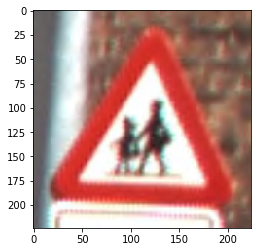

In [62]:
imshow(x_input.squeeze())

In [68]:
class LayerActivations():
    features = None
    def __init__(self, gph, nth_layer):
        self.hook = gph[nth_layer].register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.cpu().detach()
    def remove(self):
        self.hook.remove()

In [84]:
activated = LayerActivations(vgg.features,20)
_ = vgg(Variable(x_input.cuda()))
activated.remove()
activates = activated.features

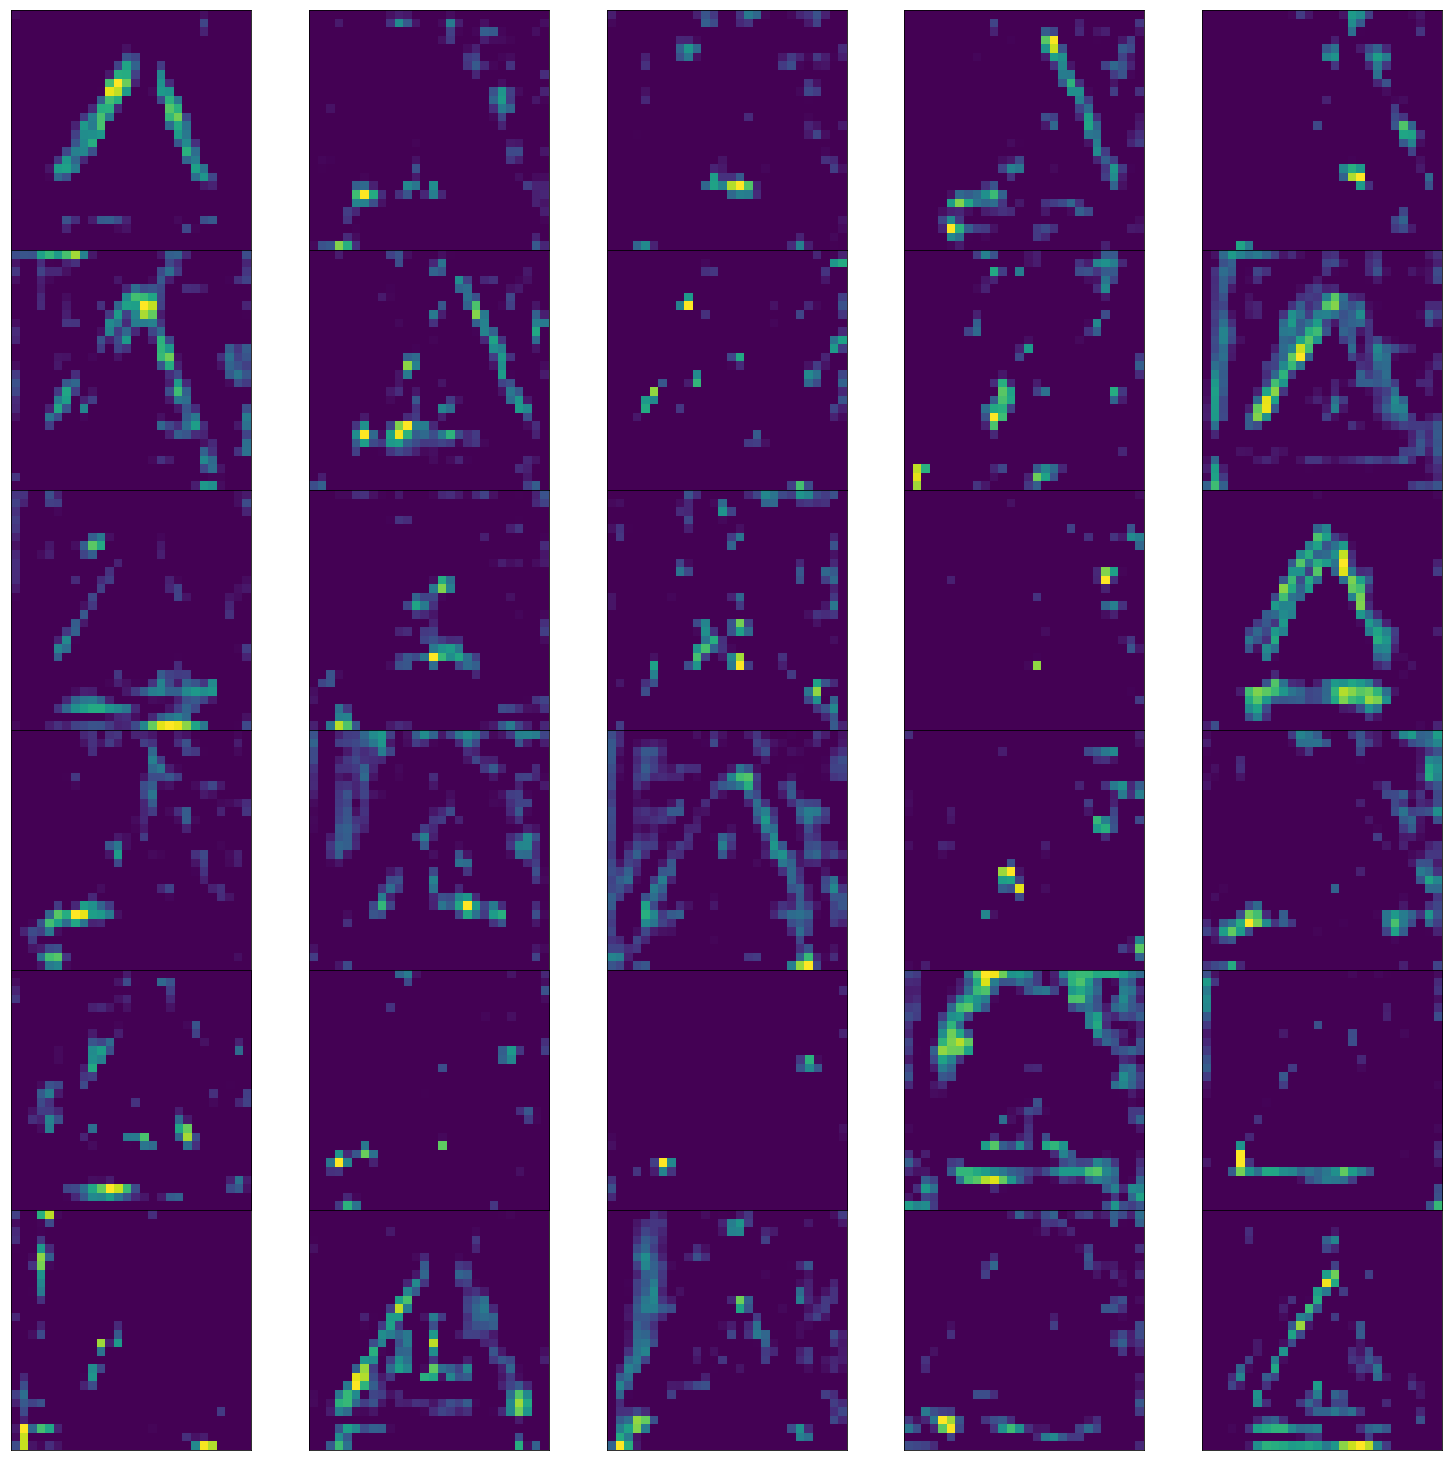

In [85]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(activates[0][i])

# Visualize Weights

In [86]:
vgg.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [87]:
weights = vgg.state_dict()['features.0.weight'].cpu()

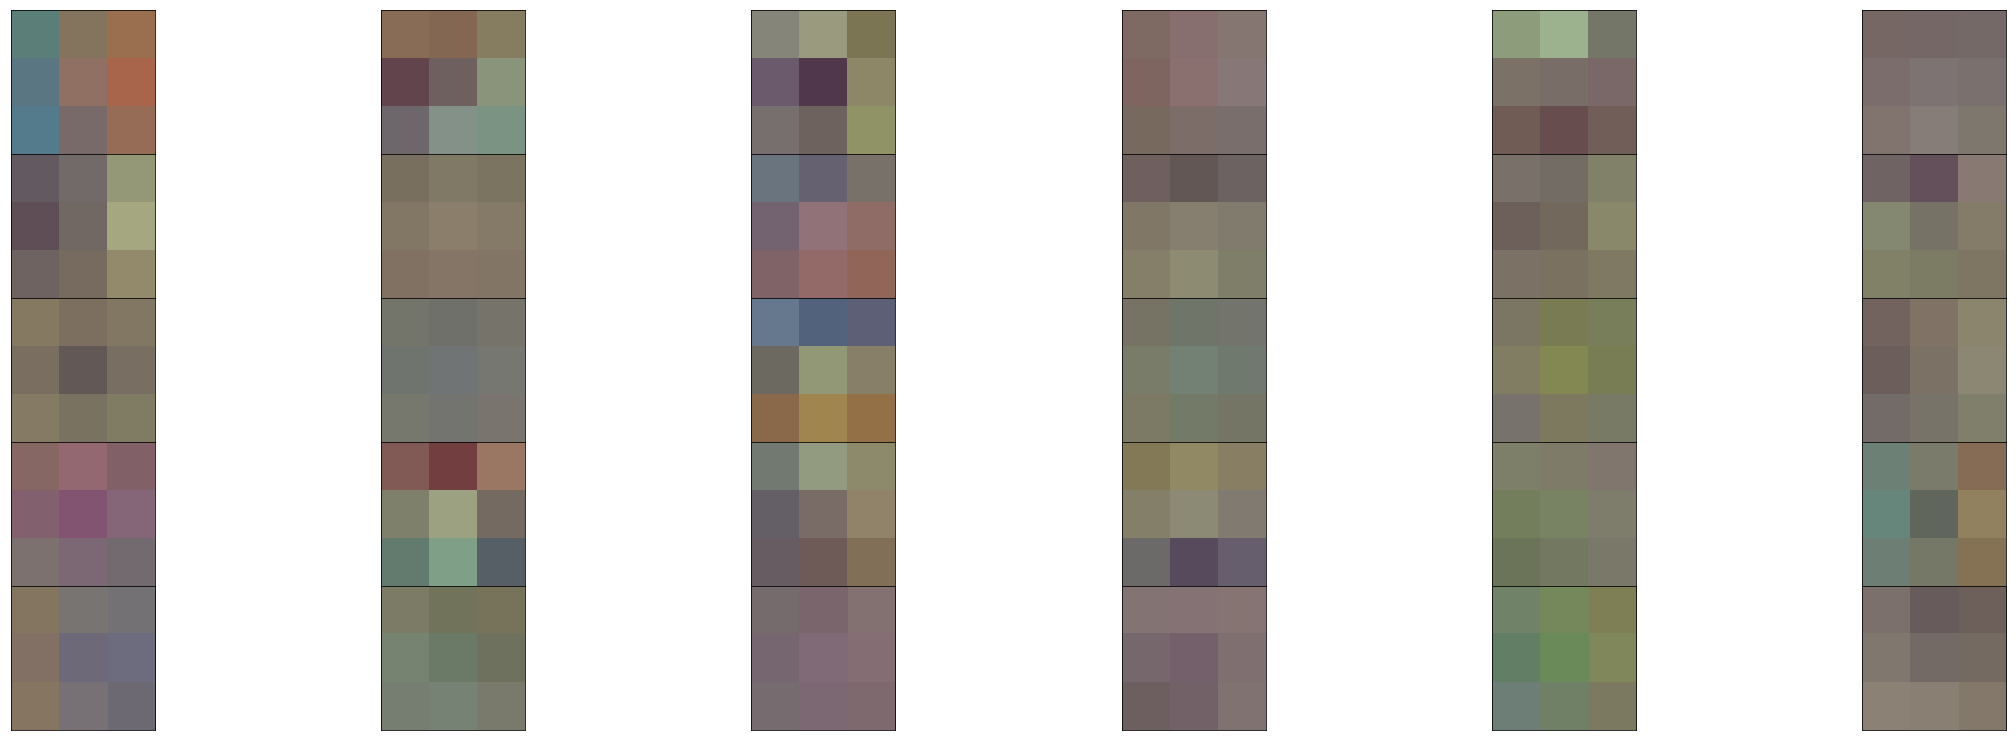

In [88]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,6,i+1,xticks=[],yticks=[])
    imshow(weights[i])